In [1]:
# Imports
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 2

# imports
import collections
import copy
import datetime
import functools
import inspect
import io
import itertools
import math
import os
import pathlib
import pdb
import random
import shutil
import textwrap
import subprocess
import sys
import shlex
import tempfile
import time
import typing
import warnings
import zipfile
from functools import partial
from pathlib import Path
from pprint import pprint as ppr

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import dotenv
import einops

# visualization libraries
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt

# Data management libraries.
import nibabel as nib
import nibabel.processing

# Computation & ML libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import skimage
import scipy
import monai
import dipy
import torch
import torch.nn.functional as F
from box import Box
from icecream import ic
from natsort import natsorted

import pitn

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)
torch.set_printoptions(sci_mode=False, threshold=100, linewidth=88)

In [2]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True)

direnv: loading ~/Projects/pitn/.envrc


True

In [3]:
# torch setup
# allow for CUDA usage, if available
if torch.cuda.is_available():
    # Pick only one device for the default, may use multiple GPUs for training later.
    if "CUDA_PYTORCH_DEVICE_IDX" in os.environ.keys():
        dev_idx = int(os.environ["CUDA_PYTORCH_DEVICE_IDX"])
    else:
        dev_idx = 0
    device = torch.device(f"cuda:{dev_idx}")
    print("CUDA Device IDX ", dev_idx)
    torch.cuda.set_device(device)
    print("CUDA Current Device ", torch.cuda.current_device())
    print("CUDA Device properties: ", torch.cuda.get_device_properties(device))
    # The flag below controls whether to allow TF32 on matmul. This flag defaults to False
    # in PyTorch 1.12 and later.
    torch.backends.cuda.matmul.allow_tf32 = True
    # See
    # <https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices>
    # for details.

    # Activate cudnn benchmarking to optimize convolution algorithm speed.
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = True
        print("CuDNN convolution optimization enabled.")
        # The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
        torch.backends.cudnn.allow_tf32 = True
else:
    device = torch.device("cpu")
# keep device as the cpu
# device = torch.device('cpu')
print(device)

CUDA Device IDX  0
CUDA Current Device  0
CUDA Device properties:  _CudaDeviceProperties(name='NVIDIA RTX A5000', major=8, minor=6, total_memory=24244MB, multi_processor_count=64)
CuDNN convolution optimization enabled.
cuda:0


## Data Loading

In [4]:
def nib_im_loader(f):
    return nib.as_closest_canonical(nib.load(f))


def nib_fdata_loader(nib_im, dtype=np.float32, **get_fdata_kwargs):
    im = nib_im.get_fdata(**get_fdata_kwargs).astype(dtype)
    if len(im.shape) == 4:
        im = np.moveaxis(im, -1, 0)
    if "caching" in get_fdata_kwargs.keys():
        if get_fdata_kwargs["caching"] == "unchanged":
            nib_im.uncache()
    return im


def log_prefix():
    return f"{datetime.datetime.now().replace(microsecond=0)}"

In [5]:
split_files = {
    # "01.1": Path("../../continuous_sr/data_splits/tmp_one-subj_HCP_train-val-test_split_01.1.csv"),
    "01.1": Path("../../continuous_sr/data_splits/HCP_train-val-test_split_01.1.csv"),
    # "02.1": Path("../../continuous_sr/data_splits/HCP_train-val-test_split_02.1.csv"),
    # "03.1": Path("../../continuous_sr/data_splits/HCP_train-val-test_split_03.1.csv"),
}

test_subj_ids_split = dict()
for split, f in split_files.items():
    d = pd.read_csv(f)
    test_subj_ids = d.loc[d.split == "test"].subj_id
    test_subj_ids = [str(i) for i in test_subj_ids.to_numpy().tolist()]
    test_subj_ids = natsorted(test_subj_ids)
    test_subj_ids_split[split] = test_subj_ids

unique_test_subj_ids = set(
    itertools.chain.from_iterable(s for s in test_subj_ids_split.values())
)
unique_test_subj_ids = natsorted(list(unique_test_subj_ids))
# Add "n/a" split for interpolation schemes which do not have a test set.
test_subj_ids_split["n/a"] = unique_test_subj_ids

In [6]:
# Prep data loading functions.
hcp_data_root_dir = Path("/data/srv/outputs/pitn/hcp")
assert hcp_data_root_dir.exists()
# Set paths relative to the subj id root dir for each required image/file.
# rel_dwi_path = Path("ras/diffusion/dwi_norm.nii.gz")
# rel_grad_table_path = Path("ras/diffusion/ras_grad_mrtrix.b")
rel_odf_path = Path("ras/odf/wm_msmt_csd_norm_odf.nii.gz")
rel_fivett_seg_path = Path("ras/segmentation/fivett_dwi-space_segmentation.nii.gz")
rel_brain_mask_path = Path("ras/brain_mask.nii.gz")

test_pred_root_dir = Path("/data/srv/outputs/pitn/results/runs")
assert test_pred_root_dir.exists()

In [7]:
# All valid permutations of subj_id x split x model_instance will be placed into a
# table.
model_instances = ("fenri_2023-10-24T21_30_01__epoch_43_step_33397", "trilinear-dwi")
instance_pred_root_dirs = (
    test_pred_root_dir / "fenri" / "2023-10-24T21_30_01" / "test_set",
    test_pred_root_dir
    / "trilinear"
    / "2023-10-24T21_31_38_trilinear_resample-dwi_odf-fit",
)
model_categories = ("FENRI", "trilinear-dwi")
instance_splits = ("01.1", "n/a")
# All tuples must have the same length where values are repeated where necessary.
assert (
    len(model_categories)
    == len(model_instances)
    == len(instance_pred_root_dirs)
    == len(instance_splits)
)

# subj_id, split, model_category, model_instance, model_pred_root_dir
pred_table = dict(
    subj_id=list(),
    split=list(),
    model_category=list(),
    model_instance=list(),
    model_pred_root_dir=list(),
)

for i in range(len(model_instances)):
    instance = model_instances[i]
    category = model_categories[i]
    split = instance_splits[i]
    pred_root_dir = str(instance_pred_root_dirs[i])
    assert Path(pred_root_dir).exists()

    subj_ids_in_split = test_subj_ids_split[split]
    for subj_id in subj_ids_in_split:
        pred_table["subj_id"].append(subj_id)
        pred_table["split"].append(split)
        pred_table["model_category"].append(category)
        pred_table["model_instance"].append(instance)
        pred_table["model_pred_root_dir"].append(str(pred_root_dir))
pred_table = pd.DataFrame.from_dict(pred_table)
# Assign the global row index as a field for later association between lists and rows.
pred_table["global_idx"] = pred_table.index
pred_table

,subj_id,split,model_category,model_instance,model_pred_root_dir,global_idx
0,100307,01.1,FENRI,fenri_2023-10-24T21_30_01__epoch_43_step_33397,/data/srv/outputs/pitn/results/runs/fenri/2023...,0
1,110613,01.1,FENRI,fenri_2023-10-24T21_30_01__epoch_43_step_33397,/data/srv/outputs/pitn/results/runs/fenri/2023...,1
2,122317,01.1,FENRI,fenri_2023-10-24T21_30_01__epoch_43_step_33397,/data/srv/outputs/pitn/results/runs/fenri/2023...,2
3,124422,01.1,FENRI,fenri_2023-10-24T21_30_01__epoch_43_step_33397,/data/srv/outputs/pitn/results/runs/fenri/2023...,3
4,133827,01.1,FENRI,fenri_2023-10-24T21_30_01__epoch_43_step_33397,/data/srv/outputs/pitn/results/runs/fenri/2023...,4
...,...,...,...,...,...,...
73,929464,n/a,trilinear-dwi,trilinear-dwi,/data/srv/outputs/pitn/results/runs/trilinear/...,73
74,933253,n/a,trilinear-dwi,trilinear-dwi,/data/srv/outputs/pitn/results/runs/trilinear/...,74
75,987074,n/a,trilinear-dwi,trilinear-dwi,/data/srv/outputs/pitn/results/runs/trilinear/...,75
76,993675,n/a,trilinear-dwi,trilinear-dwi,/data/srv/outputs/pitn/results/runs/trilinear/...,76


In [8]:
# Locate GT subject data and individual prediction files.
WAAE_MIN_AMPLITUDE = 0.1
WAAE_N_PEAKS = 3
WAAE_MRTRIX_NTHREADS = 19

TARGET_IM_ORIENTATION = "RAS"
gt_data = Box(default_box=True)
# Pred data files are linked by index of the accompanying row in the prediction table.
pred_im_data = list(range(len(pred_table)))

for subj_id in pred_table.subj_id.unique():
    print("Loading GT for", subj_id, flush=True, end="...")
    subj_data_dir = hcp_data_root_dir / subj_id
    d_i = Box(default_box=True)
    odf_im = nib.load(subj_data_dir / rel_odf_path)
    odf_im.set_data_dtype(np.float32)
    d_i.odf.im = pitn.data.io.reorient_nib_im(odf_im, TARGET_IM_ORIENTATION)

    # Derive wm mask from fivett.
    fivett_im = nib.load(subj_data_dir / rel_fivett_seg_path)
    fivett_im.set_data_dtype(np.uint8)
    fivett_im = pitn.data.io.reorient_nib_im(fivett_im, TARGET_IM_ORIENTATION)
    fivett = nib_fdata_loader(fivett_im, bool)
    wm_mask = fivett[2][None]
    d_i.wm_mask.v = wm_mask

    brain_mask_im = nib.load(subj_data_dir / rel_brain_mask_path)
    brain_mask_im.set_data_dtype(np.uint8)
    brain_mask = nib_fdata_loader(
        pitn.data.io.reorient_nib_im(brain_mask_im, TARGET_IM_ORIENTATION),
        dtype=np.uint8,
        caching="unchanged",
    )[None]
    brain_mask = brain_mask | wm_mask
    d_i.brain_mask.v = brain_mask

    # Calculate and cache the GT odf peaks for the WAAE metric.
    odf_f = subj_data_dir / rel_odf_path
    odf_f_basename = odf_f.name.replace("".join(odf_f.suffixes), "")
    gt_peaks_f = odf_f.parent / "peaks" / f"{odf_f_basename}_peaks.nii.gz"
    gt_peaks_f.parent.mkdir(exist_ok=True, parents=True)
    # Try skipping calculation of peaks, if possible.
    if not pitn.metrics.to_update_peak_cache(gt_peaks_f, n_peaks=WAAE_N_PEAKS):
        gt_peaks_im = nib.load(gt_peaks_f)
        gt_peaks_im.set_data_dtype(np.float32)
    else:
        print(f"Calculating peaks for {subj_id}", end="...", flush=True)
        affine = torch.from_numpy(d_i.odf.im.affine).unsqueeze(0)
        odf = torch.from_numpy(
            nib_fdata_loader(d_i.odf.im, dtype=np.float32, caching="unchanged")
        )
        odf = odf.unsqueeze(0)
        m = torch.from_numpy(d_i.brain_mask.v).unsqueeze(0)
        _, gt_peaks_im = pitn.metrics.odf_peaks_mrtrix(
            odf,
            affine_vox2real=affine,
            mask=m,
            n_peaks=WAAE_N_PEAKS,
            min_amp=WAAE_MIN_AMPLITUDE,
            mrtrix_nthreads=WAAE_MRTRIX_NTHREADS,
        )
        pitn.metrics.update_peak_cache(gt_peaks_im, gt_peaks_f)
        # nib.save(gt_peaks_im, gt_peaks_f)
        gt_peaks_im = nib.load(gt_peaks_f)
        gt_peaks_im.set_data_dtype(np.float32)
    # Reorienting peaks may require altering data, which is not something that should
    # be done here.
    assert (
        "".join(nib.orientations.aff2axcodes(gt_peaks_im.affine))
        == TARGET_IM_ORIENTATION
    )
    d_i.peaks.im = gt_peaks_im
    d_i.peaks.f = gt_peaks_f

    gt_data[subj_id] = d_i
    print()

print("Done loading GT data")

PredData = collections.namedtuple(
    "PredData", ("pred_row_dict", "pred_im", "pred_peaks_im")
)

for subj_id in pred_table.subj_id.unique():
    print("Loading pred data for ", subj_id, flush=True, end="...")
    subj_gt_peaks_f = gt_data[subj_id].peaks.f
    subj_gt_peaks_im = gt_data[subj_id].peaks.im
    gt_match_peaks = None
    # Load all model predictions that include this subject.
    preds_with_subj_i = pred_table[pred_table.subj_id == subj_id]
    for _, pred_row in preds_with_subj_i.iterrows():
        pred_im_data_idx = pred_row.global_idx
        pred_root_dir = Path(pred_row.model_pred_root_dir)
        pred_odf_f = pitn.utils.system.get_file_glob_unique(
            pred_root_dir, f"*{subj_id}*odf*.nii.gz"
        )
        pred_odf_im = nib.load(pred_odf_f)
        pred_odf_im = pitn.data.io.reorient_nib_im(pred_odf_im, TARGET_IM_ORIENTATION)
        # Grab or calculate prediction odf peaks.
        pred_odf_basename = pred_odf_f.name.replace("".join(pred_odf_f.suffixes), "")
        pred_peak_f = pred_odf_f.parent / "peaks" / f"{pred_odf_basename}_peaks.nii.gz"
        pred_peak_f.parent.mkdir(exist_ok=True, parents=True)
        # Check cache to see if pred peaks are present and valid.
        if not pitn.metrics.to_update_peak_cache(
            pred_peak_f, match_peaks_f=subj_gt_peaks_f, n_peaks=WAAE_N_PEAKS
        ):
            pred_peak_im = nib.load(pred_peak_f)
            pred_peak_im.set_data_dtype(np.float32)
        else:
            print(f"Calculating peaks for pred on {subj_id}", end="...", flush=True)
            affine = torch.from_numpy(pred_odf_im.affine).unsqueeze(0)
            pred_odf = torch.from_numpy(
                nib_fdata_loader(pred_odf_im, dtype=np.float32, caching="unchanged")
            ).unsqueeze(0)
            m = torch.from_numpy(gt_data[subj_id].brain_mask.v).unsqueeze(0)
            if gt_match_peaks is None:
                gt_match_peaks = torch.from_numpy(
                    subj_gt_peaks_im.get_fdata(caching="unchanged").astype(np.float32)
                ).unsqueeze(0)
            _, pred_peak_im = pitn.metrics.odf_peaks_mrtrix(
                pred_odf,
                affine_vox2real=affine,
                mask=m,
                match_peaks_vol=gt_match_peaks,
                n_peaks=WAAE_N_PEAKS,
                min_amp=WAAE_MIN_AMPLITUDE,
                mrtrix_nthreads=WAAE_MRTRIX_NTHREADS,
            )
            pitn.metrics.update_peak_cache(
                pred_peak_im, cache_f=pred_peak_f, match_peaks_f=subj_gt_peaks_f
            )
            pred_peak_im = nib.load(pred_peak_f)
            pred_peak_im.set_data_dtype(np.float32)
        # Reorienting peaks may require altering data, which is not something that should
        # be done here.
        assert (
            "".join(nib.orientations.aff2axcodes(pred_peak_im.affine))
            == TARGET_IM_ORIENTATION
        )

        pred_im_data[pred_im_data_idx] = PredData(
            pred_row.to_dict(), pred_im=pred_odf_im, pred_peaks_im=pred_peak_im
        )
    print()

print("Done loading pred data")

Loading GT for 100307...
Loading GT for 110613...
Loading GT for 122317...
Loading GT for 124422...
Loading GT for 133827...
Loading GT for 145127...
Loading GT for 147737...
Loading GT for 149236...
Loading GT for 154532...
Loading GT for 164939...
Loading GT for 165032...
Loading GT for 173536...
Loading GT for 178849...
Loading GT for 180836...
Loading GT for 185038...
Loading GT for 195647...
Loading GT for 195849...
Loading GT for 202113...
Loading GT for 204016...
Loading GT for 275645...
Loading GT for 298051...
Loading GT for 300618...
Loading GT for 353740...
Loading GT for 385450...
Loading GT for 510225...
Loading GT for 518746...
Loading GT for 529549...
Loading GT for 645450...
Loading GT for 654350...
Loading GT for 749058...
Loading GT for 767464...
Loading GT for 800941...
Loading GT for 849971...
Loading GT for 896778...
Loading GT for 929464...
Loading GT for 933253...
Loading GT for 987074...
Loading GT for 993675...
Loading GT for 994273...
Done loading GT data
Load

## Metrics

### Voxelwise

In [25]:
# All metrics must take in B x C x X x Y x Z input and target images, and a
# B x 1 x X x Y x Z bool mask, and return B x 1 x X x Y x Z voxel-wise metric images
# with the unmasked voxels set to 0.
sphere = dipy.data.get_sphere("repulsion724")
theta, phi = pitn.odf.get_torch_sample_sphere_coords(sphere, device, torch.float32)

metric_names = ("JSD", "MSE", "WAAE")
metric_fns = (
    partial(pitn.metrics.sphere_jensen_shannon_distance, theta=theta, phi=phi),
    pitn.metrics.mse_batchwise_masked,
    partial(
        pitn.metrics.waae,
        # n_peaks=WAAE_N_PEAKS,
        n_peaks=2,
        # n_peaks=3,
        odf_integral_theta=theta,  # .cpu(),
        odf_integral_phi=phi,  # .cpu(),
    ),
)

## Evaluation

### Voxel-Wise Metrics

In [26]:
VOXEL_USE_CSV = False

In [27]:
voxelwise_metrics_results_table = dict(
    subj_id=list(),
    split=list(),
    model_category=list(),
    model_instance=list(),
    tissue_mask=list(),
    metric=list(),
    mean_value=list(),
    median_value=list(),
    std_value=list(),
)

if VOXEL_USE_CSV:
    voxelwise_metrics_results_table = pd.read_csv("voxelwise_metrics_results.csv")
else:
    # for every subject
    for subj_id in pred_table.subj_id.unique():
        print(f"Starting {subj_id}", flush=True, end="...")
        d_gt = gt_data[subj_id]
        # Load ground truth data and masks.
        gt_odf = nib_fdata_loader(d_gt.odf.im, dtype=np.float32, caching="unchanged")[
            None
        ]
        gt_odf = torch.from_numpy(gt_odf).to(device)
        gt_peaks = d_gt.peaks.im.get_fdata(caching="unchanged").astype(np.float32)
        gt_peaks = torch.from_numpy(gt_peaks).unsqueeze(0).cpu()
        gt_peaks.nan_to_num_(nan=0.0)

        brain_mask = d_gt.brain_mask.v[None]
        brain_mask = torch.from_numpy(brain_mask).bool().to(device)
        wm_mask = d_gt.wm_mask.v.astype(bool)[None]
        wm_mask = torch.from_numpy(wm_mask).to(device)

        subj_preds_table = pred_table[pred_table.subj_id == subj_id]
        for _, pred_row in subj_preds_table.iterrows():
            model_category = pred_row.model_category
            model_instance = pred_row.model_instance
            split = pred_row.split
            print(f"model {model_category} split {split}", flush=True, end="...")

            pred_im_data_idx = pred_row.global_idx
            pred_data = pred_im_data[pred_im_data_idx]
            pred_im = pred_data.pred_im
            # pred_peaks_im = pred_data.pred_peaks_im
            pred_peaks = pred_data.pred_peaks_im.get_fdata().astype(np.float32)
            pred_peaks = torch.from_numpy(pred_peaks).unsqueeze(0).cpu()
            pred_peaks.nan_to_num_(nan=0.0)
            pred_odf = nib_fdata_loader(pred_im, dtype=np.float32, caching="unchanged")[
                None
            ]
            pred_odf = torch.from_numpy(pred_odf).to(device)

            gt_dims = gt_odf.shape[1]
            pred_dims = pred_odf.shape[1]
            brain_mask_dims = 1
            x = torch.cat([pred_odf.cpu(), gt_odf.cpu(), brain_mask.cpu()], dim=1)

            # for every metric
            for metric_name, fn_metric in zip(metric_names, metric_fns):
                print(f"metric {metric_name}", flush=True, end="...")
                if metric_name != "WAAE":
                    metric_vol = monai.inferers.sliding_window_inference(
                        x.cpu(),
                        roi_size=(64, 64, 64),
                        sw_batch_size=x.shape[0],
                        predictor=lambda x: fn_metric(
                            x[:, :pred_dims].to(device, non_blocking=True),
                            x[:, pred_dims : pred_dims + gt_dims].to(
                                device, non_blocking=True
                            ),
                            x[:, -brain_mask_dims:]
                            .bool()
                            .to(device, non_blocking=True),
                        ).cpu(),
                        overlap=0,
                    ).cpu()
                else:
                    metric_vol = fn_metric(
                        pred_odf.cpu().to(device),
                        gt_odf.cpu().to(device),
                        brain_mask.cpu().to(device),
                        pred_peaks.cpu().to(device),
                        gt_peaks.cpu().to(device),
                    ).cpu()
                # Square all distance values before taking the average.
                if (metric_name != "MSE") and (metric_name != "WAAE"):
                    metric_vol = metric_vol**2
                    if not metric_name.startswith("MS"):
                        metric_name = f"MS{metric_name}"

                # for all tissue masks
                for tissue_type, mask in zip(("all", "wm"), (brain_mask, wm_mask)):
                    m = mask.cpu().expand_as(metric_vol.cpu())
                    result = metric_vol[m]

                    result_mean = result.mean().detach().cpu().item()
                    result_std = torch.std(result).detach().cpu().item()
                    result_median = torch.median(result).detach().cpu().item()
                    if np.isnan(result_mean) or np.isnan(result_std):
                        raise RuntimeError(
                            f"ERROR: NaN metric on {subj_id}, {model_instance}, {tissue_type}, {metric_name}"
                        )
                    voxelwise_metrics_results_table["subj_id"].append(subj_id)
                    voxelwise_metrics_results_table["split"].append(split)
                    voxelwise_metrics_results_table["model_category"].append(
                        model_category
                    )
                    voxelwise_metrics_results_table["model_instance"].append(
                        model_instance
                    )
                    voxelwise_metrics_results_table["tissue_mask"].append(tissue_type)
                    voxelwise_metrics_results_table["metric"].append(metric_name)
                    voxelwise_metrics_results_table["mean_value"].append(result_mean)
                    voxelwise_metrics_results_table["median_value"].append(
                        result_median
                    )
                    voxelwise_metrics_results_table["std_value"].append(result_std)
        print()

    voxelwise_metrics_results_table = pd.DataFrame.from_dict(
        voxelwise_metrics_results_table
    )
    voxelwise_metrics_results_table.to_csv("voxelwise_metrics_results.csv", index=False)
voxelwise_metrics_results_table

Starting 100307...

model FENRI split 01.1...metric JSD...metric MSE...metric WAAE...model trilinear-dwi split n/a...metric JSD...metric MSE...metric WAAE...
Starting 110613...model FENRI split 01.1...metric JSD...metric MSE...metric WAAE...model trilinear-dwi split n/a...metric JSD...metric MSE...metric WAAE...
Starting 122317...model FENRI split 01.1...metric JSD...metric MSE...metric WAAE...model trilinear-dwi split n/a...metric JSD...metric MSE...metric WAAE...
Starting 124422...model FENRI split 01.1...metric JSD...metric MSE...metric WAAE...model trilinear-dwi split n/a...metric JSD...metric MSE...metric WAAE...
Starting 133827...model FENRI split 01.1...metric JSD...metric MSE...metric WAAE...model trilinear-dwi split n/a...metric JSD...metric MSE...metric WAAE...
Starting 145127...model FENRI split 01.1...metric JSD...metric MSE...metric WAAE...model trilinear-dwi split n/a...metric JSD...metric MSE...metric WAAE...
Starting 147737...model FENRI split 01.1...metric JSD...metric MSE...metric WAAE..

,subj_id,split,model_category,model_instance,tissue_mask,metric,mean_value,median_value,std_value
0,100307,01.1,FENRI,fenri_2023-10-24T21_30_01__epoch_43_step_33397,all,MSJSD,0.000213,0.000183,0.000154
1,100307,01.1,FENRI,fenri_2023-10-24T21_30_01__epoch_43_step_33397,wm,MSJSD,0.000073,0.000054,0.000057
2,100307,01.1,FENRI,fenri_2023-10-24T21_30_01__epoch_43_step_33397,all,MSE,0.000225,0.000152,0.000245
3,100307,01.1,FENRI,fenri_2023-10-24T21_30_01__epoch_43_step_33397,wm,MSE,0.000337,0.000271,0.000257
4,100307,01.1,FENRI,fenri_2023-10-24T21_30_01__epoch_43_step_33397,all,WAAE,0.007002,0.001834,0.009678
...,...,...,...,...,...,...,...,...,...
463,994273,n/a,trilinear-dwi,trilinear-dwi,wm,MSJSD,0.000193,0.000177,0.000116
464,994273,n/a,trilinear-dwi,trilinear-dwi,all,MSE,0.000881,0.000646,0.000821
465,994273,n/a,trilinear-dwi,trilinear-dwi,wm,MSE,0.001281,0.001129,0.000789
466,994273,n/a,trilinear-dwi,trilinear-dwi,all,WAAE,0.018067,0.004116,0.038502


In [28]:
voxelwise_metrics_results_table[
    np.isnan(np.array(voxelwise_metrics_results_table.mean_value))
]

,subj_id,split,model_category,model_instance,tissue_mask,metric,mean_value,median_value,std_value


/opt/mambaforge/envs/pitn/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.



<Figure size 432x288 with 0 Axes>

<Figure size 1440x660 with 0 Axes>

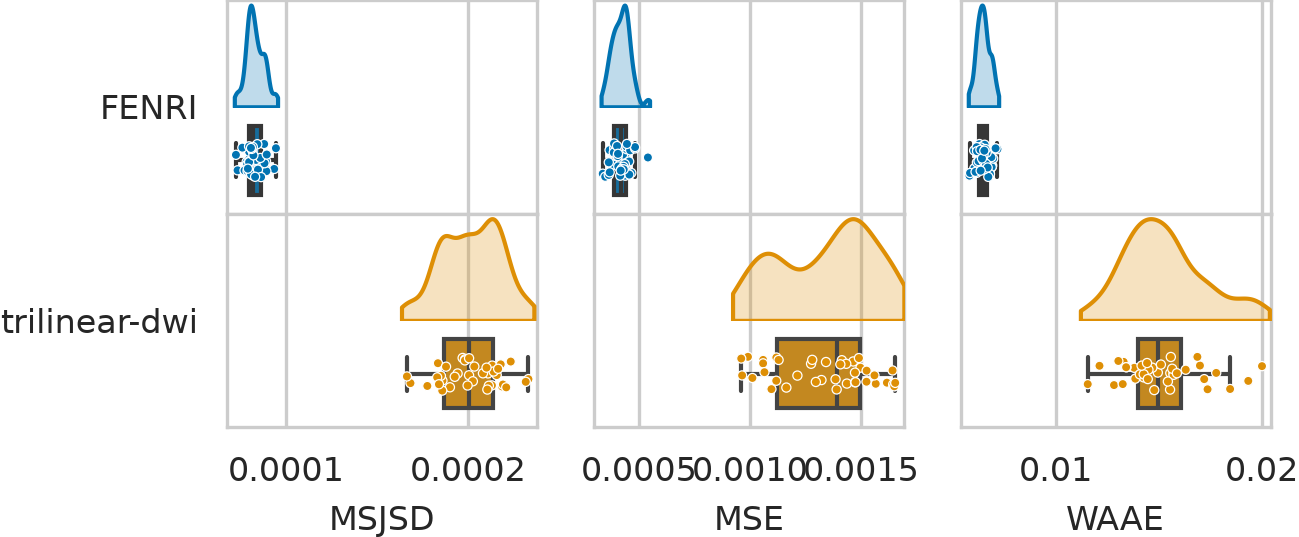

In [29]:
plot_table = voxelwise_metrics_results_table.copy()
plot_table.model_category[
    plot_table.model_category.map(lambda n: "inr" in n.casefold())
] = "FENRI"
plot_table.model_category[
    plot_table.model_category.map(lambda n: "static-cnn" in n.casefold())
] = "Static-CNN"
plot_table = plot_table[plot_table.tissue_mask.map(lambda s: s in {"wm"})]
plt.clf()

# metric_of_interest = "median_value"
metric_of_interest = "mean_value"

with mpl.rc_context(mpl.rc_params()):
    with sns.axes_style(
        "whitegrid", {"font.size": 8.0, "axes.xmargin": 0.0, "axes.ymargin": 0.0}
    ):
        figsize = dict(mpl.rc_params())["figure.figsize"]
        figsize[1] = 2.2
        fig = plt.figure(
            figsize=figsize,
            dpi=dict(mpl.rc_params())["figure.dpi"],
            layout="constrained",
        )
        # fig.set_tight_layout(False)

        unique_models = plot_table.model_category.unique().tolist()
        unique_metrics = plot_table.metric.unique().tolist()

        colors = sns.color_palette("colorblind", n_colors=len(unique_models))
        color_dict = {
            unique_models[i]: list(colors)[i] for i in range(len(unique_models))
        }
        g = sns.FacetGrid(
            plot_table,
            col="metric",
            row="model_category",
            row_order=unique_models,
            col_order=unique_metrics,
            # hue="model",
            # palette=color_dict,
            sharex="col",
            sharey="row",
            margin_titles=False,
            despine=False,
            gridspec_kws={
                "hspace": 0.0,
                # "left": 0.03,
                # "right": 0.97,
                # "top": 0.97,
                # "bottom": 0.03,
            },
        )
        g.figure.set_tight_layout(False)
        g.figure.set_figheight(fig.get_figheight())
        g.figure.set_figwidth(fig.get_figwidth())
        g = g.map_dataframe(
            sns.stripplot,
            x=metric_of_interest,
            y="model_category",
            hue="model_category",
            palette=color_dict,
            jitter=0.08,
            size=2.2,
            edgecolor="white",
            linewidth=0.3,
            legend=False,
        )
        g = g.map_dataframe(
            sns.boxplot,
            x=metric_of_interest,
            y="model_category",
            orient="h",
            palette=color_dict,
            hue="model_category",
            showfliers=False,
            width=0.33,
            linewidth=1.0,
        )
        # sns.despine(g.figure, top=True, right=False, left=False, bottom=True)
        g.set_titles("")

        # Shift all current plots down by 1/4 of the axis size.
        for ax in g.axes.flatten():
            # Shift the scatter plots/points.
            points_artist = list(
                filter(
                    lambda a: isinstance(a, mpl.collections.PathCollection),
                    ax.get_children(),
                )
            )[0]
            curr_offsets = points_artist.get_offsets().data.copy()
            curr_offsets[:, 1] += 1 / 4
            points_artist.set_offsets(curr_offsets)

            # Shift the boxplot artists.
            # This is very hardcoded right now, assumes that these artists correspond
            # to the boxplot only.
            boxplot_artists = list(ax.get_children())[1:8]
            for a in boxplot_artists:
                # The whiskers & median line.
                if isinstance(a, mpl.lines.Line2D):
                    curr_offset = a.get_ydata()
                    curr_offset = curr_offset + 1 / 4
                    a.set_ydata(curr_offset)
                # The "box" body of the plot.
                elif isinstance(a, mpl.patches.Patch):
                    curr_tf = a.get_transform()
                    aff_translate = mpl.transforms.Affine2D().translate(tx=0, ty=1 / 4)
                    new_tf = mpl.transforms.composite_transform_factory(
                        aff_translate, curr_tf
                    )
                    a.set(transform=new_tf)
                else:
                    raise RuntimeError()

        g.figure.canvas.draw()

        for (model, metric), ax in g.axes_dict.items():
            ax.set_ylabel("")
            ax.set_xmargin(0.03)
            if model == unique_models[-1]:
                ax.set_xlabel(metric)

            data = plot_table[
                (plot_table.model_category == model) & (plot_table.metric == metric)
            ].copy()

            xlim = ax.get_xlim()
            bbox_to_anchor = (xlim[0], -0.5, (xlim[1] - xlim[0]), 1 / 2)

            ax_inset = inset_axes(
                ax,
                width="100%",
                height="100%",
                loc="upper left",
                bbox_to_anchor=bbox_to_anchor,
                bbox_transform=ax.transData,
                borderpad=0,
                axes_kwargs=dict(
                    xticklabels=[],
                    yticklabels=[],
                    frame_on=False,
                    # xmargin=0.05,
                    ymargin=0.05,
                    # xmargin=0,
                    # ymargin=0,
                ),
            )
            ax_inset.set_xlim(*xlim)

            sns.kdeplot(
                data,
                x=metric_of_interest,
                hue="model_category",
                palette=color_dict,
                common_norm=False,
                fill=True,
                cut=0.5,
                legend=False,
                bw_adjust=0.75,
                ax=ax_inset,
            )
            ax_inset.set_xlabel("")
            ax_inset.set_ylabel("")
            ax_inset.grid(False)

            # tmp viz of bounding box
            # ax.add_patch(
            #     plt.Rectangle(
            #         (bbox_to_anchor[0], bbox_to_anchor[1]),
            #         bbox_to_anchor[2],
            #         bbox_to_anchor[3],
            #         lw=1,
            #         ls="--",
            #         ec="c",
            #         fc="none",
            #         transform=ax.transData,
            #         zorder=100000,
            #     )
            # )

        g
        # g.savefig("quant_results_cloud_plot.pdf", bbox_inches="tight", pad_inches=0.0)
        # g.savefig("quant_results_cloud_plot.svg", bbox_inches="tight", pad_inches=0.0)

---